# **PRÁCTICA 2**

En primer lugar, como es común en Jupyter Notebook, se procede a importar todas las librerias y que se usarán durante la práctica

In [128]:
import pandas
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.stats import norm, shapiro, mannwhitneyu
from sklearn import preprocessing, metrics
from sklearn.preprocessing import MinMaxScaler
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from scipy import stats
import re
import statistics as st

# **1. Descripción del dataset**


## **Carga del DataSet**

A continuación, procedemos a cargar el dataset extraído de Kaggle, del link: https://www.kaggle.com/ionaskel/laptop-prices. Se ha creado un enlace al link de la práctica para proceder a la carga del archivo. 

In [129]:
# Se carga el archivo con referencia al gitHub donde se encuentra el mismo
laptops_file = 'https://raw.githubusercontent.com/carlosalloUOC/PRA2-Limpieza-Analisis/main/laptops.csv'

# Se lee el fichero anterior, para transformarlo en un dataframe indicándole que en la primera línea se encuentran las cabecera
laptops_initial = pandas.read_csv(laptops_file, header=0, encoding='latin-1')

# Comprobamos que tiene las dimensiones correctas
print(laptops_initial.shape)

(1303, 13)


Se aprecia como se ha importado un dataset de 1303 filas y 13 columnas. Se puede comprabar que este hecho es correcto, ya que en la web mencionada donde se han descargado los datos se proporciona esta información. A continuación, se procede a imprimir las 5 primeras filas del dataframe, para entender el tipo de datos con el que se va a trabajar:

In [130]:
laptops_initial.head(5)

,Unnamed: 0,Company,Product,TypeName,Inches,ScreenResolution,Cpu,Ram,Memory,Gpu,OpSys,Weight,Price_euros
0,1,Apple,MacBook Pro,Ultrabook,13.3,IPS Panel Retina Display 2560x1600,Intel Core i5 2.3GHz,8GB,128GB SSD,Intel Iris Plus Graphics 640,macOS,1.37kg,1339.69
1,2,Apple,Macbook Air,Ultrabook,13.3,1440x900,Intel Core i5 1.8GHz,8GB,128GB Flash Storage,Intel HD Graphics 6000,macOS,1.34kg,898.94
2,3,HP,250 G6,Notebook,15.6,Full HD 1920x1080,Intel Core i5 7200U 2.5GHz,8GB,256GB SSD,Intel HD Graphics 620,No OS,1.86kg,575.00
3,4,Apple,MacBook Pro,Ultrabook,15.4,IPS Panel Retina Display 2880x1800,Intel Core i7 2.7GHz,16GB,512GB SSD,AMD Radeon Pro 455,macOS,1.83kg,2537.45
4,5,Apple,MacBook Pro,Ultrabook,13.3,IPS Panel Retina Display 2560x1600,Intel Core i5 3.1GHz,8GB,256GB SSD,Intel Iris Plus Graphics 650,macOS,1.37kg,1803.60


## **Descripción de variables**

Se aprecia que se cuentan con las siguientes columnas:
* Unnamed: 0	
* Company	
* Product	
* TypeName	
* Inches	
* ScreenResolution	
* Cpu	
* Ram	
* Memory	
* Gpu	
* OpSys	
* Weight	
* Price_euros

Aunque su nombre es bastante descriptivo, en la documentación se muestra la siguente información sobre estas columnas:
* Unnamed: 0	--> No da información, pero por su estructura en los datos, se aprecia que tiene tiene la mera función de ID_descendente para cada una de las columnas
* Company	--> Company Name
* Product	--> Product Name
* TypeName	--> Laptop Type
* Inches	--> Screen Inches
* ScreenResolution	--> Screen Resolution
* Cpu	--> CPU Model
* Ram	--> RAM Characteristics
* Memory	--> Memory
* Gpu	--> GPU Characteristics
* OpSys	--> Operating System
* Weight	--> Laptop's Weight
* Price_euros --> Laptop's Price

Además se aprecia que, para valores numéricos, tan solo se presenta sin unidades de medida el caso del precio (donde se indica que son euros en el nombre de la variable (Price_euros)), al igual que ocurre con el tamaño que ya se da en pulgadas. Para otros casos, como el caso del peso, la memoria o la RAM, no ocurre este hecho al proporcionarse la unidad de medida junto con el valor. Esto, como se verá en pasos posteriores, será objeto de tratamiento para poder hacer de esta manera el estudio de homegeneidad, realizar representaciones o por si se quieren construir modelos a partir de los datos. 

# **2. Integración y selección**


En esta sección, los datos con los que se van a trabajar vienen todos en un mismo dataSet, por lo que no requiere ninguna integración adicional a la importación realizada. Adicionalmente, cabe decir que si se quisieran usar dos dataSet diferentes con las mismas características, se debería de realizar una integración de los mismos en donde habría que tener en cuenta posibles repeticiones de objetos, que las propiedades se presenten en las mismas unidades... Este proceso se realizó en la práctica 1, en el momento en el que se integraban dos dataSets diferentes (uno de cada web en donde se realizó WebScraping), en uno sólo.

Respecto a la selección de los datos, nos quedaremos con todas las filas, ya que cada una de ellas corresponde a un ordenador diferente y aporta información al estudio que se está realizando. Ademas, nos encontramos ante un número de ordenadores (1003) no tan grande como para tener que hacer reducción de la cantidad. Sin embargo, para el caso de tener que realizar el mismo, consideramos que las dos mejores formas de hacerlo serían el método de muestra aleatoria simple sin sustitución (para no tener repeticiones de ordenadores en el dataSet resultante), o muestra de clústeres, en donde cada cluster podría estar correspondido por la marca o por intervalos de precio para asegurar que tenemos muestras de todos los precios. 

Si que en este apartado sería interesante hacer una división de los datos en muestra y test para por si posteriormente se usaran datos para realizar modelos. Sin embargo, este paso se realizará más adelante cuando se haya hecho el proceso de limpieza completo de los datos, ya que sino habría que realizar el proceso dos veces. 

Sobre las columnas, encontramos la primera de ellas que no nos da ninguna información útil para el estudio y ser un simple id ascendente, con lo cual la eliminaremos. Haremos lo mismo con la columna que se refiere al producto, pues el objetivo en todo momento es realizar una comparación en base a características o marcas, pero no en base al modelo del portátil directamente.


In [131]:
# Eliminamos la columna Unnamed: 0
del laptops_initial["Unnamed: 0"]

# Eliminamos la columna Product
del laptops_initial["Product"]

#Imprimimos los datos para comprobar la correcta eliminación
laptops_initial.head(5)

,Company,TypeName,Inches,ScreenResolution,Cpu,Ram,Memory,Gpu,OpSys,Weight,Price_euros
0,Apple,Ultrabook,13.3,IPS Panel Retina Display 2560x1600,Intel Core i5 2.3GHz,8GB,128GB SSD,Intel Iris Plus Graphics 640,macOS,1.37kg,1339.69
1,Apple,Ultrabook,13.3,1440x900,Intel Core i5 1.8GHz,8GB,128GB Flash Storage,Intel HD Graphics 6000,macOS,1.34kg,898.94
2,HP,Notebook,15.6,Full HD 1920x1080,Intel Core i5 7200U 2.5GHz,8GB,256GB SSD,Intel HD Graphics 620,No OS,1.86kg,575.00
3,Apple,Ultrabook,15.4,IPS Panel Retina Display 2880x1800,Intel Core i7 2.7GHz,16GB,512GB SSD,AMD Radeon Pro 455,macOS,1.83kg,2537.45
4,Apple,Ultrabook,13.3,IPS Panel Retina Display 2560x1600,Intel Core i5 3.1GHz,8GB,256GB SSD,Intel Iris Plus Graphics 650,macOS,1.37kg,1803.60


# **3. Limpieza de los datos**


## **Elementos vacíos I**

En este apartado se prestará atención a los valores que se presentan como nulos o incluso a los que, sin ser nulos, presentan valores anormales que indicarían que nos encontramos ante un caso de elemento vacío o perdido (por ejemplo, el hecho de que en pulgadas se encuentre un 0)

Se comenzará con los valores nulos del dataFrame. Para ello, en primer lugar se hará un resumen de valores nulos por columna:

In [132]:
laptops_initial.isnull().sum()

Company             0
TypeName            0
Inches              0
ScreenResolution    0
Cpu                 0
Ram                 0
Memory              0
Gpu                 0
OpSys               0
Weight              0
Price_euros         0
dtype: int64

Vemos como no hay ningún valor nulo. Para datasets con más columnas es más útil ver si hay algún valor nulo por medio del booleano, para que si este resulta verdadero, mirar dónde está el mismo

In [133]:
laptops_initial.isnull().values.any()

False

Aunque no se han encontrado datos vacíos, se ha de prestar atención a que no se presenten en forma de string del tipo "No available". Esto se realizará en el apartado "Elementos vacíos II", una vez los datos hayan sido sido preparados para el estudio

## **Preparación de datos**

Es interesante realizar una limpieza de las variables para su posterior tratamiento.

En primer lugar, centraremos la atención para que las variables que puedan ser consideradas como numéricas (Inches, Ram, Weight o Price_euros), sean tratadas así. Para el caso de Inches o Price_euros esto ya ocurre, pero para Ram o Weight no ocurre al aparecer sus unidades de medida como son GB o Kg. 

Aunque parece que en el dataSet todas las medidas están dadas en GB y Kg, lo primero que se realizará será ver si para todas las columnas se cumple este hecho. Comenzamos por la Ram:

In [134]:
#Se realiza un splitado en base a 'GB'
split_ram_value = laptops_initial['Ram'].str.split('GB', 0, expand=True)
#Se comprueba que todos los valores son numericos (no lo serían si hubiera otra medida)
split_ram_value[0].str.isnumeric().unique()

array([ True])

Se aprecia que todos los valores que se encuentran en la variable RAM vienen dados en GB, ya que al realizar el splitado se ha comprobado que en la primera posición del resultado se encuentran todo numeros enteros, por lo que será usaran estos valores numéricos posteriormente (almacenados en split_ram_value[0]).

De forma similar, se realizará el mismo estudio para la columna peso, peso con su unidad de Kg 


In [135]:
# Se realiza un splitado en base a 'kg'
split_weight_value = laptops_initial['Weight'].str.split('kg', 0, expand=True)

# Se comprueba que todos los valores son enteros como en el caso anterior o float. Para ello, se define la función is_valid_decimal que
# indicará si un numero es dicimal (True) o no lo es:
def is_valid_decimal(string):
    try:
        float(string)
        return True
    except ValueError:
        return False

# Se crea un objeto serie para almacenar los resultados
is_weight_decimal = pandas.Series([])

# Se recorre la serie con los posibles números resultantes del splitado, y se van añadiendo a la serie creada
for index, value in split_weight_value[0].items():
    is_weight_decimal[index] = is_valid_decimal(value)
    
# Vemos los diferentes valores que contiene le vector (si todos son true, todos serán valores float por lo que todos serán kg)
is_weight_decimal.unique()

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:14: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  


array([ True])

Por lo tanto, una vez se ha comprobado que ambas columnas eliminando la medida tiene un valor numérico, se procede a transformar estas columnas a numericas. Para ello, la unidad de medida, al ser en todas ellas la misma se incluirá en la columna a la que corresponde:

In [136]:
# Se renombran las columnas, añadiendo los GB a la RAM y los KG al peso
laptops_initial = laptops_initial.rename(columns={'Ram': 'Ram(GB)', 'Weight': 'Weight(Kg)'})

# Se hace el camnio en estas columnas por los números extraídos
laptops_initial["Ram(GB)"] = split_ram_value[0]
laptops_initial["Weight(Kg)"] = split_weight_value[0]

# Se imprime la cabecera
laptops_initial.head(5)

,Company,TypeName,Inches,ScreenResolution,Cpu,Ram(GB),Memory,Gpu,OpSys,Weight(Kg),Price_euros
0,Apple,Ultrabook,13.3,IPS Panel Retina Display 2560x1600,Intel Core i5 2.3GHz,8,128GB SSD,Intel Iris Plus Graphics 640,macOS,1.37,1339.69
1,Apple,Ultrabook,13.3,1440x900,Intel Core i5 1.8GHz,8,128GB Flash Storage,Intel HD Graphics 6000,macOS,1.34,898.94
2,HP,Notebook,15.6,Full HD 1920x1080,Intel Core i5 7200U 2.5GHz,8,256GB SSD,Intel HD Graphics 620,No OS,1.86,575.00
3,Apple,Ultrabook,15.4,IPS Panel Retina Display 2880x1800,Intel Core i7 2.7GHz,16,512GB SSD,AMD Radeon Pro 455,macOS,1.83,2537.45
4,Apple,Ultrabook,13.3,IPS Panel Retina Display 2560x1600,Intel Core i5 3.1GHz,8,256GB SSD,Intel Iris Plus Graphics 650,macOS,1.37,1803.60


Una vez se tienen estos datos correctamente transformados, se ponen de tipo numérico las columnas mencionadas

In [137]:
# Transformamos esta columnas al tipo numérico
laptops_initial["Ram(GB)"] = pandas.to_numeric(laptops_initial["Ram(GB)"])
laptops_initial["Weight(Kg)"] = pandas.to_numeric(laptops_initial["Weight(Kg)"])
laptops_initial["Inches"] = pandas.to_numeric(laptops_initial["Inches"])
laptops_initial["Price_euros"] = pandas.to_numeric(laptops_initial["Price_euros"])
laptops_initial.head(5)

,Company,TypeName,Inches,ScreenResolution,Cpu,Ram(GB),Memory,Gpu,OpSys,Weight(Kg),Price_euros
0,Apple,Ultrabook,13.3,IPS Panel Retina Display 2560x1600,Intel Core i5 2.3GHz,8,128GB SSD,Intel Iris Plus Graphics 640,macOS,1.37,1339.69
1,Apple,Ultrabook,13.3,1440x900,Intel Core i5 1.8GHz,8,128GB Flash Storage,Intel HD Graphics 6000,macOS,1.34,898.94
2,HP,Notebook,15.6,Full HD 1920x1080,Intel Core i5 7200U 2.5GHz,8,256GB SSD,Intel HD Graphics 620,No OS,1.86,575.00
3,Apple,Ultrabook,15.4,IPS Panel Retina Display 2880x1800,Intel Core i7 2.7GHz,16,512GB SSD,AMD Radeon Pro 455,macOS,1.83,2537.45
4,Apple,Ultrabook,13.3,IPS Panel Retina Display 2560x1600,Intel Core i5 3.1GHz,8,256GB SSD,Intel Iris Plus Graphics 650,macOS,1.37,1803.60


Prestando atención a la variable Memoria, vemos que hay dos partes bastante diferenciadas. Aparentemente, en un primer lugar encontramos la unidad de memoria (que sería un caso parecido al atratado con la RAM), y por otro, el tipo de memoria. Por lo tanto, en un primer lugar se analizarán los tipos de memoria de los que disponemos, haciendo el splitado en base al primer espacio:

In [138]:
# Se realiza un splitado en base tan solo al primer espacio , ya que es lo aparentemente separa la cantidad de memoria y el tipo
split_memory_value = laptops_initial['Memory'].str.split(' ', 1, expand=True)

# Imprimimos las segundas partes del splitado
split_memory_value[1].unique()

array(['SSD', 'Flash Storage', 'HDD', 'SSD +  1TB HDD',
       'SSD +  256GB SSD', 'SSD +  2TB HDD', 'Hybrid', 'SSD +  500GB HDD',
       'SSD +  512GB SSD', 'Flash Storage +  1TB HDD', 'HDD +  1TB HDD',
       'SSD +  1.0TB Hybrid'], dtype=object)

Vemos que nos encontramos ante un problema imprevisto. Al ser tantos datos, se acaba de comprobar que la estructura de cantidad de almacenamiento + tipo no siempre es así, pudiendo a veces combinarse combinaciones de varios tipos de memoria. Además, también con respecto a las unidades, parece que no todas son GB como en el caso anterior. Encontramos en este punto unidades tanto en GB como en TB. 

Haremos un primer estudio sobre a cuántos datos afecta este hecho de estar formado por más de un tipo de memoria.  

In [139]:
 laptops_initial[laptops_initial['Memory'].str.contains(' + ')]

,Company,TypeName,Inches,ScreenResolution,Cpu,Ram(GB),Memory,Gpu,OpSys,Weight(Kg),Price_euros
21,Lenovo,Gaming,15.6,IPS Panel Full HD 1920x1080,Intel Core i5 7300HQ 2.5GHz,8,128GB SSD + 1TB HDD,Nvidia GeForce GTX 1050,Windows 10,2.50,999.0
28,Dell,Ultrabook,15.6,Full HD 1920x1080,Intel Core i7 8650U 1.9GHz,8,256GB SSD + 256GB SSD,Intel UHD Graphics 620,Windows 10,1.88,1298.0
37,Dell,Notebook,17.3,IPS Panel Full HD 1920x1080,Intel Core i5 8250U 1.6GHz,8,128GB SSD + 1TB HDD,AMD Radeon 530,Windows 10,2.80,979.0
41,Dell,Gaming,15.6,IPS Panel Full HD 1920x1080,Intel Core i7 7700HQ 2.8GHz,16,256GB SSD + 1TB HDD,Nvidia GeForce GTX 1060,Windows 10,2.65,1499.0
47,Asus,Gaming,17.3,Full HD 1920x1080,AMD Ryzen 1700 3GHz,8,256GB SSD + 1TB HDD,AMD Radeon RX 580,Windows 10,3.20,1299.0
...,...,...,...,...,...,...,...,...,...,...,...
1238,MSI,Gaming,15.6,Full HD 1920x1080,Intel Core i7 6700HQ 2.6GHz,8,128GB SSD + 1TB HDD,Nvidia GeForce GTX 960M,Windows 10,2.30,1169.0
1245,Asus,Gaming,15.6,IPS Panel Full HD 1920x1080,Intel Core i7 7700HQ 2.8GHz,16,256GB SSD + 1TB HDD,Nvidia GeForce GTX 1050 Ti,Windows 10,2.50,1600.0
1247,Asus,Gaming,15.6,IPS Panel Full HD 1920x1080,Intel Core i7 6700HQ 2.6GHz,16,256GB SSD + 1TB HDD,Nvidia GeForce GTX 1070,Windows 10,2.34,2325.0
1256,Asus,Gaming,17.3,IPS Panel Full HD 1920x1080,Intel Core i7 6700HQ 2.6GHz,16,128GB SSD + 1TB HDD,Nvidia GeForce GTX 970M,Windows 10,4.00,1900.0


Contamos con 4 tipos de memoria: 
* SSD
* Flash Storage
* HDD
* Hybrid

Que se presentan de forma única o con las siguientes combinaciones:
* SSD +  SSD
* HDD +  HDD
* SSD +  HDD
* Flash Storage +  HDD
* SSD +  Hybrid

Teniendo estas en cuenta, se elaborará una serie para cada una de ellas, con el fin de tener controlado tanto el tipo de memoria como su valor. Se había pensado también en juntar los valores de ambas memorias en tan solo una columna, indicando en el tipo de memoria el conjunto de memorias a las que pertenece. Sin embargo, al realizar esto, se perdería información relevante, ya que no es lo mismo una memoria SSD y una HDD!

Adicionalmente, se escogerá la unidad de medida de GB, ya que es la que más presente está. Se deberá de tener en cuenta que 1TB serán 1024GB, ya que son las dos medidas que aparecen.

In [140]:
# Se crea un objeto serie para almacenar cada tipo de memoria
ssd_value = pandas.Series([])
flash_value = pandas.Series([])
hdd_value = pandas.Series([])
hybrid_value = pandas.Series([])

# Devuelve los GB a partir de la unidad de memoria proporcionada 
def convert_GB(memoryNumber):
  if "GB" in memoryNumber:
    return (float(memoryNumber.split('GB')[0]))
  else:
    return (float(memoryNumber.split('TB')[0])*1024)

# Devuelve el tipo de memoria principal (la que aparece en primer lugar)
def get_primary_type(secondaryMemory):
  secondaryMemory_split_plus = secondaryMemory.split(' +  ')
  return secondaryMemory_split_plus[0]

# Devuelve el tipo de memoria secundaria (la que aparece en segundo lugar)
def get_secondary_type(secondaryMemory):
  secondaryMemory_split_plus = secondaryMemory.split(' +  ')
  secondaryMemory_split_value =secondaryMemory_split_plus[1].split(' ')
  return secondaryMemory_split_value[1]

# Devuelve el valor de memoria secundaria (la que aparece en segundo lugar)
def get_secondary_value(secondaryMemory):
  secondaryMemory_split_plus = secondaryMemory.split(' +  ')
  secondaryMemory_split_value =secondaryMemory_split_plus[1].split(' ')
  return secondaryMemory_split_value[0]


# Se recorre la serie con los posibles números resultantes del splitado, y se van añadiendo a la serie creada
for index, value in split_memory_value[0].items():
  # El primer caso será el que incluya un + en el string, hecho que indica que esta compuesto por dos tipos de memoria
  if " + " in split_memory_value[1][index]:
    # Se extrae el valor y el tipo secundario 
    primary_type = get_primary_type(split_memory_value[1][index])
    secondary_value = get_secondary_value(split_memory_value[1][index])
    secondary_type = get_secondary_type(split_memory_value[1][index])
    # Se comprueban que si ambos son del mismo tipo (ocurre con SSD o HDD), en cuyo caso habrá que sumar estos valores
    if (primary_type == secondary_type):
      if (primary_type == 'HDD'):
        hdd_value[index] = convert_GB(split_memory_value[0][index]) + convert_GB(secondary_value)
        ssd_value[index] = 0
        hybrid_value[index] = 0
        flash_value[index] = 0
      else:
        ssd_value[index] = convert_GB(split_memory_value[0][index]) + convert_GB(secondary_value)
        hdd_value[index] = 0
        hybrid_value[index] = 0
        flash_value[index] = 0
    # En el caso de que no sean igual, se trata de dos tipos de memorias diferentes, en donde teniendo en cuentas las combinaciones posibles en base a las combinaciones vistas anteriormente
    else:
      if (primary_type == 'SSD' and secondary_type == 'HDD'):
        ssd_value[index] = convert_GB(split_memory_value[0][index])
        hdd_value[index] = convert_GB(secondary_value)
        hybrid_value[index] = 0
        flash_value[index] = 0
      elif (primary_type == 'Flash Storage' and secondary_type == 'HDD'):
        ssd_value[index] = 0
        hdd_value[index] = convert_GB(secondary_value)
        hybrid_value[index] = 0
        flash_value[index] = convert_GB(split_memory_value[0][index])
      elif (primary_type == 'SSD' and secondary_type == 'Hybrid'):
        ssd_value[index] = convert_GB(split_memory_value[0][index])
        hdd_value[index] = 0
        hybrid_value[index] = convert_GB(secondary_value)
        flash_value[index] = 0

  # En el caso de que no se encuentre la particula +, será porque sólo tiene un tipo de memoria, por lo que buscaremos cual es y lo introduciremos a la serie, dejando el resto de valores
  # de la memoria que no corresponda a 0
  else:
    # Si es SSD, rellenamos la serie de SSD, mientras que en las demás introdimos un 0, al no contar con esa memoria
    if split_memory_value[1][index] == 'SSD':
      ssd_value[index] = convert_GB(split_memory_value[0][index])
      hdd_value[index] = 0
      hybrid_value[index] = 0
      flash_value[index] = 0
    elif split_memory_value[1][index] == 'HDD':
      hdd_value[index] = convert_GB(split_memory_value[0][index])
      ssd_value[index] = 0
      hybrid_value[index] = 0
      flash_value[index] = 0
    elif split_memory_value[1][index] == 'Hybrid':
      hybrid_value[index] = convert_GB(split_memory_value[0][index])
      ssd_value[index] = 0
      hdd_value[index] = 0
      flash_value[index] = 0
    elif split_memory_value[1][index] == 'Flash Storage':
      flash_value[index] = convert_GB(split_memory_value[0][index])
      ssd_value[index] = 0
      hdd_value[index] = 0
      hybrid_value[index] = 0

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  This is separate from the ipykernel package so we can avoid doing imports until
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  after removing the cwd from sys.path.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:5: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify

Para comprobar que se ha hecho bien el cambio, se imprimirá uno de los casos especiales (que incluyen dos tipos de memoria), y que se ha visto en el printeo de los mismos. Este será la muestra 21, que tiene segun vemos en la tabla: 128GB SSD + 1TB HDD	

In [141]:
print('Valor SSD en GB: ' + str(ssd_value[21]))
print('Valor HDD en GB: ' + str(hdd_value[21]))

Valor SSD en GB: 128.0
Valor HDD en GB: 1024.0


Una vez hecho este proceso, se colocarán las 4 nuevas columnas con cada tipo de memoria, siendo este un valor numérico:

In [142]:
# Introducimos las nuevas columnas
laptops_initial["MemorySSD(GB)"] = ssd_value
laptops_initial["MemoryHDD(GB)"] = hdd_value
laptops_initial["MemoryFlash(GB)"] = flash_value
laptops_initial["MemoryHybrid(GB)"] = hybrid_value

# Las transformamos a numéricas
laptops_initial["MemorySSD(GB)"] = pandas.to_numeric(laptops_initial["MemorySSD(GB)"])
laptops_initial["MemoryHDD(GB)"] = pandas.to_numeric(laptops_initial["MemoryHDD(GB)"])
laptops_initial["MemoryFlash(GB)"] = pandas.to_numeric(laptops_initial["MemoryFlash(GB)"])
laptops_initial["MemoryHybrid(GB)"] = pandas.to_numeric(laptops_initial["MemoryHybrid(GB)"])

# Eliminamos la columna inicial que tenia los datos de la memoria sin limpiar
del laptops_initial["Memory"]

# Verificamos la correcta creación
laptops_initial.head(5)

,Company,TypeName,Inches,ScreenResolution,Cpu,Ram(GB),Gpu,OpSys,Weight(Kg),Price_euros,MemorySSD(GB),MemoryHDD(GB),MemoryFlash(GB),MemoryHybrid(GB)
0,Apple,Ultrabook,13.3,IPS Panel Retina Display 2560x1600,Intel Core i5 2.3GHz,8,Intel Iris Plus Graphics 640,macOS,1.37,1339.69,128.0,0.0,0.0,0.0
1,Apple,Ultrabook,13.3,1440x900,Intel Core i5 1.8GHz,8,Intel HD Graphics 6000,macOS,1.34,898.94,0.0,0.0,128.0,0.0
2,HP,Notebook,15.6,Full HD 1920x1080,Intel Core i5 7200U 2.5GHz,8,Intel HD Graphics 620,No OS,1.86,575.00,256.0,0.0,0.0,0.0
3,Apple,Ultrabook,15.4,IPS Panel Retina Display 2880x1800,Intel Core i7 2.7GHz,16,AMD Radeon Pro 455,macOS,1.83,2537.45,512.0,0.0,0.0,0.0
4,Apple,Ultrabook,13.3,IPS Panel Retina Display 2560x1600,Intel Core i5 3.1GHz,8,Intel Iris Plus Graphics 650,macOS,1.37,1803.60,256.0,0.0,0.0,0.0


Se procederá ahora a realizar una sepación de la CPU. Aparentemente, parece que en una primera partaparece la empresa que la proporciona, en segundo la versión que se proporciona, y por último, la velocidad del mismo. Como siempre, se comprueba gracias a la programación que para todos ocurre esto (ya que al contar con 1303 muestras, no nos podemos fijar tan solo en las 5 primeras)


In [143]:
# Se realiza un splitado en base al primer espacio, dejando en la primera parte la supuesta marca, mientras que en la segunda el resto
split_cpu_company_value = laptops_initial['Cpu'].str.split(' ', 1, expand=True)

# Almacenamos las marcas de cpu
company_cpu = split_cpu_company_value[0]

# Comprobamos que efectivamente todas ellas corresponden a marcas
company_cpu.unique()

array(['Intel', 'AMD', 'Samsung'], dtype=object)

Se aprecia como en esta ocasión, se está en lo cierto y tan solo hay 3 marcas. Procederemos ahora a ver los tipos de productos trabajando con la parte del splitado anterior no usada

In [144]:
# Se realiza un splitado de la segunda parte, en donde el mismo se realizará en base al último espacio, al ser la estructura VERSION + ' ' + VELOCIDAD
split_cpu_version_and_speed_value = split_cpu_company_value[1].str.rsplit(' ', 1, expand=True)

# Sacamos las versiones, que estarán en la primera parte del splitado
version_cpu=split_cpu_version_and_speed_value[0]

# Comprobamos que todas ellas son versiones
version_cpu.unique()

array(['Core i5', 'Core i5 7200U', 'Core i7', 'A9-Series 9420',
       'Core i7 8550U', 'Core i5 8250U', 'Core i3 6006U', 'Core M m3',
       'Core i7 7500U', 'Core i3 7100U', 'Atom x5-Z8350',
       'Core i5 7300HQ', 'E-Series E2-9000e', 'Core i7 8650U',
       'Atom x5-Z8300', 'E-Series E2-6110', 'A6-Series 9220',
       'Celeron Dual Core N3350', 'Core i3 7130U', 'Core i7 7700HQ',
       'Ryzen 1700', 'Pentium Quad Core N4200', 'Atom x5-Z8550',
       'Celeron Dual Core N3060', 'FX 9830P', 'Core i7 7560U',
       'E-Series 6110', 'Core i5 6200U', 'Core M 6Y75', 'Core i5 7500U',
       'Core i7 6920HQ', 'Core i5 7Y54', 'Core i7 7820HK',
       'Xeon E3-1505M V6', 'Core i7 6500U', 'E-Series 9000e',
       'A10-Series A10-9620P', 'A6-Series A6-9220', 'Core i7 6600U',
       'Celeron Dual Core 3205U', 'Core i7 7820HQ', 'A10-Series 9600P',
       'Core i7 7600U', 'A8-Series 7410', 'Celeron Dual Core 3855U',
       'Pentium Quad Core N3710', 'A12-Series 9720P', 'Core i5 7300U',
       'Ce

En este caso tenemos más versiones que marcas, pero vemos como todas ellas son versiones de los diferentes proveedores, por lo que tan solo quedará comprobar que, efectivamente, el final de este string coincide en todos casos con velocidades

In [145]:
# Sacamos las velocidades, que estarán en la seguna parte del splitado anterior
speed_cpu=split_cpu_version_and_speed_value[1]
speed_cpu.unique()

array(['2.3GHz', '1.8GHz', '2.5GHz', '2.7GHz', '3.1GHz', '3GHz', '2.2GHz',
       '1.6GHz', '2GHz', '2.8GHz', '1.2GHz', '2.9GHz', '2.4GHz',
       '1.44GHz', '1.5GHz', '1.9GHz', '1.1GHz', '2.0GHz', '1.3GHz',
       '2.6GHz', '3.6GHz', '1.60GHz', '3.2GHz', '1.0GHz', '2.1GHz',
       '0.9GHz', '1.92GHz', '2.50GHz', '2.70GHz'], dtype=object)

También se aprecia que todas son frecuencias y además en la misma medida, por lo que parece ser que estábamos en lo cierto en base a que lo que ocurre con las 5 primeras muestras, se replica para el resto de ellas. Por tanto, se dividirá esta columna en 3, ya que será más eficiente a la hora de hacer análisis y gráficas. Para le valor numérico, como en casos anteriores, se eliminará la unidad de medida de las muestras poniendo esta en la cabecera

In [146]:
# Se realiza un splitado en base a 'GHz'
speed_cpu_split = speed_cpu.str.split('GHz', 0, expand=True)
# Se crea la serie sin medidas
speed_cpu_GHz = speed_cpu_split[0]

Finalmente, se crean estas columnas y se le da el tipo numérico a la última de ellas

In [147]:
# Introducimos las nuevas columnas
laptops_initial["CPU_Company"] = company_cpu
laptops_initial["CPU_Version"] = version_cpu
laptops_initial["CPU_Speed(GHz)"] = speed_cpu_GHz

# La transformamos a numéricas
laptops_initial["CPU_Speed(GHz)"] = pandas.to_numeric(laptops_initial["CPU_Speed(GHz)"])

# Eliminamos la columna inicial que tenia los datos de la CPU sin limpiar
del laptops_initial["Cpu"]

# Verificamos la correcta creación
laptops_initial.head(5)

,Company,TypeName,Inches,ScreenResolution,Ram(GB),Gpu,OpSys,Weight(Kg),Price_euros,MemorySSD(GB),MemoryHDD(GB),MemoryFlash(GB),MemoryHybrid(GB),CPU_Company,CPU_Version,CPU_Speed(GHz)
0,Apple,Ultrabook,13.3,IPS Panel Retina Display 2560x1600,8,Intel Iris Plus Graphics 640,macOS,1.37,1339.69,128.0,0.0,0.0,0.0,Intel,Core i5,2.3
1,Apple,Ultrabook,13.3,1440x900,8,Intel HD Graphics 6000,macOS,1.34,898.94,0.0,0.0,128.0,0.0,Intel,Core i5,1.8
2,HP,Notebook,15.6,Full HD 1920x1080,8,Intel HD Graphics 620,No OS,1.86,575.00,256.0,0.0,0.0,0.0,Intel,Core i5 7200U,2.5
3,Apple,Ultrabook,15.4,IPS Panel Retina Display 2880x1800,16,AMD Radeon Pro 455,macOS,1.83,2537.45,512.0,0.0,0.0,0.0,Intel,Core i7,2.7
4,Apple,Ultrabook,13.3,IPS Panel Retina Display 2560x1600,8,Intel Iris Plus Graphics 650,macOS,1.37,1803.60,256.0,0.0,0.0,0.0,Intel,Core i5,3.1


Se aprecia que para la GPU parece seguir una estructura similar: VENDEDOR + VERSION. Siguiendo el mismo proceso que el anterior, nos encontraríamos:

In [148]:
# Se realiza un splitado en base al primer espacio, dejando en la primera parte la supuesta marca, mientras que en la segunda la versión
split_gpu_company_and_model = laptops_initial['Gpu'].str.split(' ', 1, expand=True)

# Almacenamos las marcas de Gpu
company_gpu = split_gpu_company_and_model[0]

# Comprobamos que efectivamente todas ellas corresponden a marcas
company_gpu.unique()

array(['Intel', 'AMD', 'Nvidia', 'ARM'], dtype=object)

In [149]:
# Almacenamos las versiones de Gpu
version_gpu = split_gpu_company_and_model[1]

# Comprobamos que efectivamente todas ellas corresponden a marcas
version_gpu.unique()

array(['Iris Plus Graphics 640', 'HD Graphics 6000', 'HD Graphics 620',
       'Radeon Pro 455', 'Iris Plus Graphics 650', 'Radeon R5',
       'Iris Pro Graphics', 'GeForce MX150', 'UHD Graphics 620',
       'HD Graphics 520', 'Radeon Pro 555', 'Radeon R5 M430',
       'HD Graphics 615', 'Radeon Pro 560', 'GeForce 940MX',
       'HD Graphics 400', 'GeForce GTX 1050', 'Radeon R2', 'Radeon 530',
       'GeForce 930MX', 'HD Graphics', 'HD Graphics 500',
       'GeForce 930MX ', 'GeForce GTX 1060', 'GeForce 150MX',
       'Iris Graphics 540', 'Radeon RX 580', 'GeForce 920MX',
       'Radeon R4 Graphics', 'Radeon 520', 'GeForce GTX 1070',
       'GeForce GTX 1050 Ti', 'GeForce MX130', 'R4 Graphics',
       'GeForce GTX 940MX', 'Radeon RX 560', 'GeForce 920M',
       'Radeon R7 M445', 'Radeon RX 550', 'GeForce GTX 1050M',
       'HD Graphics 515', 'Radeon R5 M420', 'HD Graphics 505',
       'GTX 980 SLI', 'R17M-M1-70', 'GeForce GTX 1080', 'Quadro M1200',
       'GeForce 920MX ', 'GeForce GTX

Vemos como de esta manera facilitamos análisis posteriores, sobre todo en lo referente a la marca, en donde podremos estudiar si la misma influye en el precio. Añadiendo estas columnas a nuestro dataFrame

In [150]:
# Introducimos las nuevas columnas
laptops_initial["GPU_Company"] = company_gpu
laptops_initial["GPU_Version"] = version_gpu

# Eliminamos la columna inicial que tenia los datos de la GPU sin limpiar
del laptops_initial["Gpu"]

# Verificamos la correcta creación
laptops_initial.head(5)

,Company,TypeName,Inches,ScreenResolution,Ram(GB),OpSys,Weight(Kg),Price_euros,MemorySSD(GB),MemoryHDD(GB),MemoryFlash(GB),MemoryHybrid(GB),CPU_Company,CPU_Version,CPU_Speed(GHz),GPU_Company,GPU_Version
0,Apple,Ultrabook,13.3,IPS Panel Retina Display 2560x1600,8,macOS,1.37,1339.69,128.0,0.0,0.0,0.0,Intel,Core i5,2.3,Intel,Iris Plus Graphics 640
1,Apple,Ultrabook,13.3,1440x900,8,macOS,1.34,898.94,0.0,0.0,128.0,0.0,Intel,Core i5,1.8,Intel,HD Graphics 6000
2,HP,Notebook,15.6,Full HD 1920x1080,8,No OS,1.86,575.00,256.0,0.0,0.0,0.0,Intel,Core i5 7200U,2.5,Intel,HD Graphics 620
3,Apple,Ultrabook,15.4,IPS Panel Retina Display 2880x1800,16,macOS,1.83,2537.45,512.0,0.0,0.0,0.0,Intel,Core i7,2.7,AMD,Radeon Pro 455
4,Apple,Ultrabook,13.3,IPS Panel Retina Display 2560x1600,8,macOS,1.37,1803.60,256.0,0.0,0.0,0.0,Intel,Core i5,3.1,Intel,Iris Plus Graphics 650


Finalmente, para la resolución, la divideremos en dos partes. La primera de ellas, de extraer la resolución en píxeles por una expresión regex:

In [151]:
# Limpieza columna ScreenResolution (se dejan los valores que indican únicamente la resolución en píxeles)
pixels_ScreenResolution = laptops_initial.ScreenResolution.str.extract("(\d+x\d+)", expand=False)

# Se comprueba que no hay nulos (que para todos los valores se ha conseguido obtener los pixeles)
pixels_ScreenResolution.isnull().sum()


0

Para poder tratarlas numéricamente, se extraerá el la parte de los píxeles a lo alto y a lo ancho, separados en todas las medidas por una x

In [152]:
# Se realiza un splitado en base a la x
split_pixels_value = pixels_ScreenResolution.str.split('x', 0, expand=True)

# Se separan en ancho (width) y alto (high)
split_pixels_width = split_pixels_value[0]
split_pixels_high = split_pixels_value[1]

Una vez realizado este hecho, se extraerá también tipo de resolución que presenta el ordenador. Mientras que todas las muestras traían los pixeles, en este caso no ocurrirá lo mismo, ya que se ve en las 5 primeras muestras como en la segunda (id 1), no se presenta el tipo. 

In [153]:
# Se realiza un splitado en base al último espacio, ya que si tiene tipo, en la primera variable de este splitado estará el mismo
# y si no lo tiene, estarán los píxeles sacados anteriormente
split_pixels_by_last_space = laptops_initial.ScreenResolution.str.rsplit(' ', 1, expand=True)

# Se crea un objeto serie para almacenar los tipos
type_pixels = pandas.Series([])

# Comprobamos uno a uno si son igualas a los píxeles (no tiene tipo) o si no lo son (tiene el tipo)
for index, value in split_pixels_by_last_space[0].items():
  if (split_pixels_by_last_space[0][index] == pixels_ScreenResolution[index]):
    type_pixels[index]=np.NaN
  else:
    type_pixels[index]=split_pixels_by_last_space[0][index]

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  


En este caso, como es de esperar aparecerán nulos que serán tratados en la sección Elementos vacíos II. Introducimos los nuevos valores en el dataframe 

In [154]:
# Introducimos las nuevas columnas
laptops_initial["ScreenResolution_Type"] = type_pixels
laptops_initial["ScreenResolution_Width"] = split_pixels_width
laptops_initial["ScreenResolution_High"] = split_pixels_high

# La transformamos a numéricas las dos últimas
laptops_initial["ScreenResolution_Width"] = pandas.to_numeric(laptops_initial["ScreenResolution_Width"])
laptops_initial["ScreenResolution_High"] = pandas.to_numeric(laptops_initial["ScreenResolution_High"])

# Eliminamos la columna inicial que tenia los datos de ScreenResolution sin limpiar
del laptops_initial["ScreenResolution"]

#Verificamos la correcta creación
laptops_initial.head(5)

,Company,TypeName,Inches,Ram(GB),OpSys,Weight(Kg),Price_euros,MemorySSD(GB),MemoryHDD(GB),MemoryFlash(GB),MemoryHybrid(GB),CPU_Company,CPU_Version,CPU_Speed(GHz),GPU_Company,GPU_Version,ScreenResolution_Type,ScreenResolution_Width,ScreenResolution_High
0,Apple,Ultrabook,13.3,8,macOS,1.37,1339.69,128.0,0.0,0.0,0.0,Intel,Core i5,2.3,Intel,Iris Plus Graphics 640,IPS Panel Retina Display,2560,1600
1,Apple,Ultrabook,13.3,8,macOS,1.34,898.94,0.0,0.0,128.0,0.0,Intel,Core i5,1.8,Intel,HD Graphics 6000,NaN,1440,900
2,HP,Notebook,15.6,8,No OS,1.86,575.00,256.0,0.0,0.0,0.0,Intel,Core i5 7200U,2.5,Intel,HD Graphics 620,Full HD,1920,1080
3,Apple,Ultrabook,15.4,16,macOS,1.83,2537.45,512.0,0.0,0.0,0.0,Intel,Core i7,2.7,AMD,Radeon Pro 455,IPS Panel Retina Display,2880,1800
4,Apple,Ultrabook,13.3,8,macOS,1.37,1803.60,256.0,0.0,0.0,0.0,Intel,Core i5,3.1,Intel,Iris Plus Graphics 650,IPS Panel Retina Display,2560,1600


## **Elementos vacíos II**

En este momento, se comprobará si se han introducido valores nulos en el dataFrame. Tan sólo sería esperado en el apartado de tipo de resolución de pantalla, en donde se ha visto que algunas no disponían de esta información

In [155]:
laptops_initial.isnull().sum()

Company                     0
TypeName                    0
Inches                      0
Ram(GB)                     0
OpSys                       0
Weight(Kg)                  0
Price_euros                 0
MemorySSD(GB)               0
MemoryHDD(GB)               0
MemoryFlash(GB)             0
MemoryHybrid(GB)            0
CPU_Company                 0
CPU_Version                 0
CPU_Speed(GHz)              0
GPU_Company                 0
GPU_Version                 0
ScreenResolution_Type     314
ScreenResolution_Width      0
ScreenResolution_High       0
dtype: int64

Efectivamente, se aprecia como para este caso se encuentran solo valores vacíos en la variable ScreenResolution_Type. Para su tratamiento, se realizará el método de indiciar los valores perdidos como la sustitución por una misma constante o etiqueta, en este caso, "Unknown". Esto se hace ya que falta un gran número de registro (un 33%), y el uso de otras técnicas como la moda harían que tuvieramos muchísimos datos 'no reales'. Otras técnicas basadas en modelos que lo predicen, tampoco las vemos oportunadas, ya que siendo un atributo como es el tipo de resolución, podría darse el caso de que dos ordenadores tuvieran las mismas características, y sin embargo, un tipo de resolución diferencia. Por tanto, aplicando esto al dataFrame:

In [156]:
# Cambiamos los valores nulos por el literal Unknow
laptops_initial["ScreenResolution_Type"].fillna("Unknown", inplace = True)

# Verificamos que no queda ningún valor nulo
laptops_initial.ScreenResolution_Type.isnull().sum()

0

Finalemente, para las variables con las que se han tratado, se ha visto como no hay valores que indiquen valores nulos o vacíos. Faltaría tratar ver los valores de las columnas que no se han tratado todavía: 
* Company	
* TypeName
* OpSys

Para comprobar que no hay valores nulos en estas variables, se imprimirán los diferentes valores que contiene cada una

In [157]:
laptops_initial['Company'].unique()

array(['Apple', 'HP', 'Acer', 'Asus', 'Dell', 'Lenovo', 'Chuwi', 'MSI',
       'Microsoft', 'Toshiba', 'Huawei', 'Xiaomi', 'Vero', 'Razer',
       'Mediacom', 'Samsung', 'Google', 'Fujitsu', 'LG'], dtype=object)

In [158]:
laptops_initial['TypeName'].unique()

array(['Ultrabook', 'Notebook', 'Netbook', 'Gaming', '2 in 1 Convertible',
       'Workstation'], dtype=object)

In [159]:
laptops_initial['OpSys'].unique()

array(['macOS', 'No OS', 'Windows 10', 'Mac OS X', 'Linux', 'Android',
       'Windows 10 S', 'Chrome OS', 'Windows 7'], dtype=object)

Se puede apreciar como para todos los casos se encuentran valores no vacíos. Si bien es verdad que para sistema operativo encontramos 'No OS', que puede dar lugar a confusión. Sin embargo, este valor es válido, ya que algunos ordenadores pueden no tener sistema operativo integradado, y por tanto, posiblemente, abarate el coste del mismo

## **Valores extremos**

Se analizarán a continuación los valores extremos, empezando por la variable más relevante para el estudio: price_euros. En un primer momento, se realizará un análisis descriptivo de esta variable numérica, estudiando sus diferentes percentiles:

In [160]:
# Percentiles y resumen estadístico de la columna de precios
laptops_initial["Price_euros"].describe()

count    1303.000000
mean     1123.686992
std       699.009043
min       174.000000
25%       599.000000
50%       977.000000
75%      1487.880000
max      6099.000000
Name: Price_euros, dtype: float64

Se aprecia como aparentemente, aunque el percentil 50 está en 977 y su 75 en 1487, la media es de 1123, lo que es indicio de que, tras el percentil 75 encontraremos algún valor más elevado, hasta llegar al máximo de 6099. Estudiaremos gráficamente en una recta la situación de estos datos

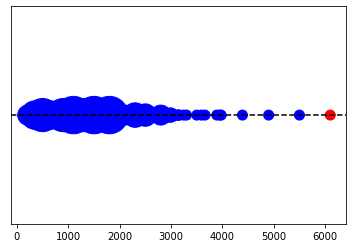

In [161]:
# Extraemos cada precio y el número de veces que salen
price_unique, counts = np.unique(laptops_initial['Price_euros'], return_counts=True)

# Representamos de azul los valores en donde se concentran la mayoría de las filas
# y en rojo las que se alejan de esta
sizes = counts*100
colors = ['blue']*len(price_unique)
colors[-1] = 'red'
plt.axhline(1, color='k', linestyle='--')
plt.scatter(price_unique, np.ones(len(price_unique)), s=sizes, color=colors)
plt.yticks([])
plt.show()

Se aprecia como hay una gran concentración de datos en la zona en torno a 1000 euros, y que va disminuyendo hasta llegar hasta los 3000, en donde los precios a partir de este punto empiezan a encontrarse más distantes hasta llegar a los 6000, que la función cataloga como punto alejado o outlier. Una forma más visual y algo más matemática de verlo sería por medio de los boxplots:

{'boxes': [<matplotlib.lines.Line2D at 0x7f00b893d2d0>],
 'caps': [<matplotlib.lines.Line2D at 0x7f00b89422d0>,
 'fliers': [<matplotlib.lines.Line2D at 0x7f00b892b250>],
 'means': [],
 'medians': [<matplotlib.lines.Line2D at 0x7f00b892bcd0>],
 'whiskers': [<matplotlib.lines.Line2D at 0x7f00b89317d0>,
  <matplotlib.lines.Line2D at 0x7f00b8942d50>]}

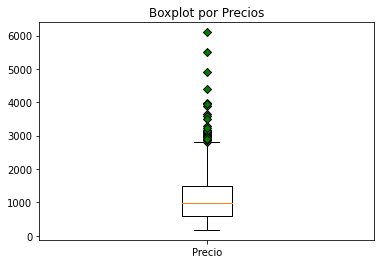

In [162]:
# Construción de boxplot
green_diamond = dict(markerfacecolor='g', marker='D')
fig, ax = plt.subplots()
ax.set_title('Boxplot por Precios')
ax.boxplot(laptops_initial['Price_euros'], flierprops=green_diamond, labels=["Precio"])

En este, se aprecia información como la que se ha comentado en párrafos anteriores. En esta gráfica se aprecia como, los puntos por encima de la T, son catalogados como extremos o anómalos. Estudiemos en el dataSet estos casos, para ver si efectivamente se tratan de outliers que debemos de eliminar o tratar al ser posibles valores incorrectos o los mismos son puntos de interés de nuestro análisis y han de estar presentes.

In [163]:
# Ordenar los ordenadores por precio, e imprimir las columnas más caras
laptops_initial.sort_values('Price_euros').tail(10)

,Company,TypeName,Inches,Ram(GB),OpSys,Weight(Kg),Price_euros,MemorySSD(GB),MemoryHDD(GB),MemoryFlash(GB),MemoryHybrid(GB),CPU_Company,CPU_Version,CPU_Speed(GHz),GPU_Company,GPU_Version,ScreenResolution_Type,ScreenResolution_Width,ScreenResolution_High
1231,Razer,Gaming,14.0,16,Windows 10,1.95,3499.0,1024.0,0.0,0.0,0.0,Intel,Core i7 7700HQ,2.8,Nvidia,GeForce GTX 1060,Full HD,1920,1080
780,Dell,Gaming,17.3,32,Windows 10,4.42,3588.8,1024.0,1024.0,0.0,0.0,Intel,Core i7 7700HQ,2.8,Nvidia,GeForce GTX 1070M,IPS Panel Full HD,1920,1080
723,Dell,Gaming,17.3,32,Windows 10,4.36,3659.4,1024.0,1024.0,0.0,0.0,Intel,Core i7 7700HQ,2.8,Nvidia,GeForce GTX 1070,4K Ultra HD,3840,2160
238,Asus,Gaming,17.3,32,Windows 10,4.70,3890.0,512.0,1024.0,0.0,0.0,Intel,Core i7 7820HK,2.9,Nvidia,GeForce GTX 1080,Full HD,1920,1080
1136,HP,Workstation,17.3,8,Windows 7,3.00,3949.4,256.0,0.0,0.0,0.0,Intel,Core i7 6700HQ,2.6,Nvidia,Quadro M3000M,IPS Panel Full HD,1920,1080
1066,Asus,Gaming,17.3,64,Windows 10,3.58,3975.0,1024.0,0.0,0.0,0.0,Intel,Core i7 6820HK,2.7,Nvidia,GeForce GTX 980,IPS Panel Full HD,1920,1080
749,HP,Workstation,17.3,16,Windows 7,3.00,4389.0,256.0,0.0,0.0,0.0,Intel,Xeon E3-1535M v5,2.9,Nvidia,Quadro M2000M,IPS Panel Full HD,1920,1080
610,Lenovo,Notebook,15.6,32,Windows 10,2.50,4899.0,1024.0,0.0,0.0,0.0,Intel,Xeon E3-1535M v6,3.1,Nvidia,Quadro M2200M,IPS Panel 4K Ultra HD,3840,2160
830,Razer,Gaming,17.3,32,Windows 10,3.49,5499.0,512.0,0.0,0.0,0.0,Intel,Core i7 7820HK,2.9,Nvidia,GeForce GTX 1080,4K Ultra HD / Touchscreen,3840,2160
196,Razer,Gaming,17.3,32,Windows 10,3.49,6099.0,1024.0,0.0,0.0,0.0,Intel,Core i7 7820HK,2.9,Nvidia,GeForce GTX 1080,4K Ultra HD / Touchscreen,3840,2160


Se aprecia como sin duda, en la gran mayoría encontramos en esta sección ordenadores Gaming, los cuales necesitan una capacidad mayores que los ordenadores estándar para el día a día. Además, vemos por ejemplo que la diferencia entre los dos últimos reside en la diferencia de la memoria SSD, ya que las demás características son iguales. Por lo general, vemos que todos estos ordenadores, presentan una CPU y GPU muy potente, que consultando el precio de estas en el mercado, parece ser un elemento que aumentará bastante el precio. Para confirmar este hecho, vamos a realizar un resumen de estos ordenadores


In [164]:
 laptops_initial[laptops_initial['TypeName']=='Gaming'].describe()

,Inches,Ram(GB),Weight(Kg),Price_euros,MemorySSD(GB),MemoryHDD(GB),MemoryFlash(GB),MemoryHybrid(GB),CPU_Speed(GHz),ScreenResolution_Width,ScreenResolution_High
count,205.000000,205.000000,205.000000,205.000000,205.000000,205.000000,205.0,205.000000,205.000000,205.000000,205.000000
mean,16.345854,14.048780,2.949761,1731.380634,236.019512,879.141463,0.0,19.980488,2.722439,2048.000000,1152.000000
std,0.927174,7.234013,0.759205,814.174430,189.474608,423.528276,0.0,141.982875,0.142057,471.666216,265.312247
min,14.000000,4.000000,1.600000,699.000000,0.000000,0.000000,0.0,0.000000,2.100000,1920.000000,1080.000000
25%,15.600000,8.000000,2.430000,1169.000000,128.000000,1024.000000,0.0,0.000000,2.600000,1920.000000,1080.000000
50%,15.600000,16.000000,2.700000,1492.800000,256.000000,1024.000000,0.0,0.000000,2.800000,1920.000000,1080.000000
75%,17.300000,16.000000,3.350000,2199.000000,256.000000,1024.000000,0.0,0.000000,2.800000,1920.000000,1080.000000
max,18.400000,64.000000,4.700000,6099.000000,1024.000000,2048.000000,0.0,1024.000000,3.200000,3840.000000,2160.000000


Se aprecia que aunque encontramos también algún ordenador barato de estas características (699), la mayoría, incrementan todos los percentiles vistos anteriormente. Además, con el resto de característimas de rendimiento como la CPU, presentan valores altos en donde desde el percentil 50 toma el valor de 2.8, llegando a tomar 3.2 en su máximo.



Centrando ahora el estudio para el caso del peso:


{'boxes': [<matplotlib.lines.Line2D at 0x7f00ae549810>],
 'caps': [<matplotlib.lines.Line2D at 0x7f00ae547850>,
 'fliers': [<matplotlib.lines.Line2D at 0x7f00ae54e890>],
 'means': [],
 'medians': [<matplotlib.lines.Line2D at 0x7f00ae54e350>],
 'whiskers': [<matplotlib.lines.Line2D at 0x7f00b89440d0>,
  <matplotlib.lines.Line2D at 0x7f00ae549b10>]}

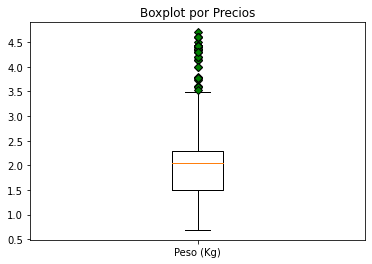

In [165]:
# Construción de boxplot
green_diamond = dict(markerfacecolor='g', marker='D')
fig, ax = plt.subplots()
ax.set_title('Boxplot por Precios')
ax.boxplot(laptops_initial['Weight(Kg)'], flierprops=green_diamond, labels=["Peso (Kg)"])

Se aprecia como se vuelven a tener varios registros que se alejan "por arriba" del conjunto de los demás datos. Para ello, volveremos a ver de que ordenadores se trata:

In [166]:
 laptops_initial[laptops_initial['Weight(Kg)']>3.5]

,Company,TypeName,Inches,Ram(GB),OpSys,Weight(Kg),Price_euros,MemorySSD(GB),MemoryHDD(GB),MemoryFlash(GB),MemoryHybrid(GB),CPU_Company,CPU_Version,CPU_Speed(GHz),GPU_Company,GPU_Version,ScreenResolution_Type,ScreenResolution_Width,ScreenResolution_High
177,MSI,Gaming,18.4,32,Windows 10,4.40,2799.00,512.0,1024.0,0.0,0.0,Intel,Core i7 6920HQ,2.9,Nvidia,GTX 980 SLI,Full HD,1920,1080
224,Dell,Gaming,17.3,16,Windows 10,4.42,2456.34,256.0,1024.0,0.0,0.0,Intel,Core i7 7700HQ,2.8,Nvidia,GeForce GTX 1060,IPS Panel Full HD,1920,1080
238,Asus,Gaming,17.3,32,Windows 10,4.70,3890.00,512.0,1024.0,0.0,0.0,Intel,Core i7 7820HK,2.9,Nvidia,GeForce GTX 1080,Full HD,1920,1080
247,Asus,Gaming,17.3,16,Windows 10,3.60,2999.00,256.0,0.0,0.0,0.0,Intel,Core i7 7820HK,2.9,Nvidia,GeForce GTX 1080,Full HD,1920,1080
251,Asus,Gaming,17.3,16,Windows 10,4.30,1799.00,256.0,1024.0,0.0,0.0,Intel,Core i7 7700HQ,2.8,Nvidia,GeForce GTX 980M,Full HD,1920,1080
258,MSI,Gaming,17.3,16,Windows 10,4.14,2499.00,512.0,1024.0,0.0,0.0,Intel,Core i7 7700HQ,2.8,Nvidia,GeForce GTX 1070,Full HD,1920,1080
424,Dell,Gaming,17.3,16,Windows 10,4.42,2799.00,256.0,1024.0,0.0,0.0,Intel,Core i7 7820HK,2.9,Nvidia,GeForce GTX 1070,IPS Panel,2560,1440
456,Dell,Notebook,17.3,8,Windows 10,4.42,2046.00,0.0,1024.0,0.0,0.0,Intel,Core i7 7700HQ,2.7,Nvidia,GeForce GTX 1060,IPS Panel Full HD,1920,1080
468,HP,Gaming,17.3,12,Windows 10,3.78,1699.00,0.0,1024.0,0.0,0.0,Intel,Core i7 7700HQ,2.8,Nvidia,GeForce GTX 1060,IPS Panel Full HD,1920,1080
494,Asus,Gaming,17.3,24,Windows 10,4.33,1269.00,256.0,1024.0,0.0,0.0,Intel,Core i7 6700HQ,2.6,Nvidia,GeForce GTX 965M,IPS Panel Full HD / Touchscreen,1920,1080


Se aprecia como, de nuevo, vuelve a tratarse de ordenadores Gaming, los cuales parece ser que pesan más que los "normales", posiblemente, debido a que presentan componentes más pesados y pesados, siendo ordenadores centrados en el rendimiento y no tanto en la portabilidad. 
Para comprobar cómo estos ordenadores no son mayoría, se realizará un gráfico de barras en función del tipo de ordeandor:

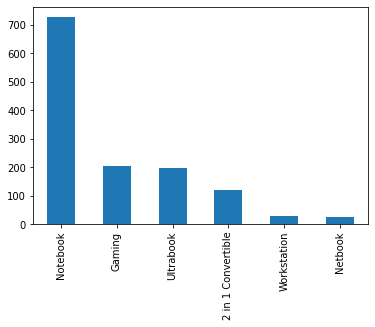

In [167]:
laptops_initial['TypeName'].value_counts().plot.bar()
plt.show()

Se aprecia como el tipo Notebook es el más presente en el dataSet, y por tanto, el que concetrará más ordeandores de las mismas características. El resto de ordenadores, aunque tienen diferentes funcionalidades, tienen un uso parecido entre ellos (notebook, ultrabook o 2 en 1), en donde sus diferencias en términos de características son pequeñas (que la pantalla sea táctil, que sea mas transportable...). Sin embargo, los gaming, suelen ser ordenadores más potentes, y habitualmente, más grandes, alejándose del resto de los ordenadores que hacen que se presente esta diferencia, y no por ello son datos inválidos. Serán simplemente, como el nombre del apartado indica, valores extremos. 

Para el resto de variables numéricas, no tiene tanto sentido elaborar este estudio, ya que aunque son valores numéricos, son valores que no son continuos como tal, ya que las medidas dadas en GB son medidas específicas (8-16-64...), al igual que ocurre con los tamaños de pantalla, en donde suelen ser tamaños estandarizados (alto-ancho) y no llegan a ser continuos como tal. Además, estos valores se han visto en la preparación de datos anteriores, y no ha apreciado ningún valor fuera de lo común o medida desmesurada para un ordenador.

# **4. Análisis de los datos**

La variable objetivo de este conjunto de datos es la variable de Price_euros, debido a que en apartados posteriores, realizaremos un contraste de medias y un modelo de regresión lineal.

En el contraste de medias, estudiaremos si se puede afirmar que es estadísticamente significativo que los productos de Apple tengan un coste más elevado que el resto de marcas. 

En la regresión lineal, se realizará un modelo que trate de predecir el precio de un dispositivo teniendo en cuenta sus características técnicas. Para ello, se hará uso de las variables independientes que muestren tener más impacto en el cálculo final del producto, realizando un análisis de sus distribuciones y correlación.

## **Contraste de medias**

Tal y como se ha indicado anteriormente, procedemos en este apartado a realizar un constraste de medias que nos indicará si los productos de Apple son significativamente más caros, de media, que el resto de productos de otras marcas. 

Para ello, separaremos primero el dataset en dos de tal forma que contengan respectivamente los precios de los productos de Apple y del resto de marcas.

In [168]:
apple_prices = laptops_initial[laptops_initial["Company"] == "Apple"]["Price_euros"]
other_prices = laptops_initial[laptops_initial["Company"] != "Apple"]["Price_euros"]
print(apple_prices.head(5))
print(other_prices.head(5))

print(f'Precio medio de los productos de Apple: {round(st.mean(apple_prices), 2)}.')
print(f'Precio medio de los productos de otras marcas: {round(st.mean(other_prices), 2)}.')

0    1339.69
1     898.94
3    2537.45
4    1803.60
6    2139.97
Name: Price_euros, dtype: float64
2      575.0
5      400.0
8     1495.0
9      770.0
10     393.9
Name: Price_euros, dtype: float64
Precio medio de los productos de Apple: 1564.2.
Precio medio de los productos de otras marcas: 1116.47.


Una vez separadas las muestras, estudiamos la normalidad de cada una de ellas:

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


(0.8930661678314209, 0.025735169649124146)

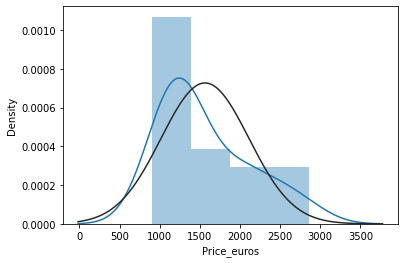

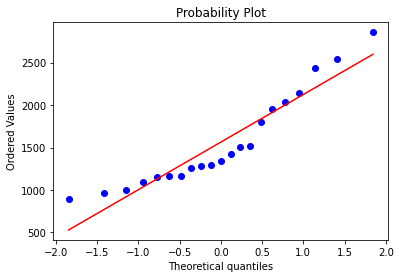

In [169]:
# Histograma y gráfico de probabilidad normal de los precios de Apple:

sns.distplot(apple_prices, fit = norm);
fig = plt.figure()
res = stats.probplot(apple_prices, plot = plt)

# Prueba de Shapiro-Wilk
stat, p = shapiro(apple_prices)
stat, p

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


(0.8909043669700623, 3.601114643371191e-29)

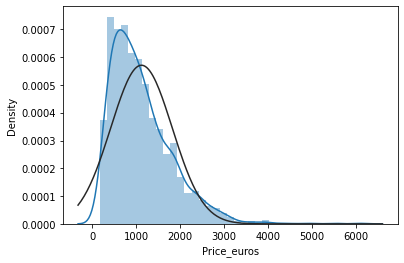

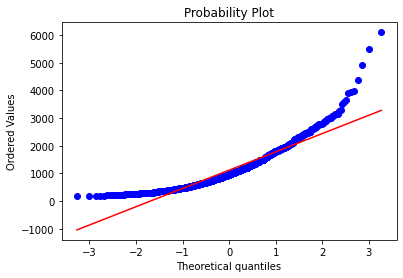

In [170]:
# Histograma y gráfico de probabilidad normal de los precios del resto de marcas:

sns.distplot(other_prices, fit = norm);
fig = plt.figure()
res = stats.probplot(other_prices, plot = plt)

# Prueba de Shapiro-Wilk
stat, p = shapiro(other_prices)
stat, p

En base a los resultados obtenidos, no es posible garantizar la normalidad en la distribución de las muestras de precios tanto de apple como de otras marcas dado que el test de Shapiro rechaza la hipótesis nula de normalidad. Asimismo, en el caso del subset de Apple, no sería posible tampoco aplicar el teorema del límite central al no superar las 30 muestras. 

En este sentido, para poder confirmar si podemos asumir homocedasticidad (igualdad de varianzas entre muestras) debemos aplicar el test de Fligner-Killeen (no paramétrico) al no poder suponer normalidad:

In [171]:
# Fligner-Killeen test
fligner_test = stats.fligner(apple_prices, other_prices, center='median')
fligner_test

FlignerResult(statistic=0.9821213321141975, pvalue=0.32167564402079707)

A raíz de los resultados (p value >> 0.05) no podemos descartar la hipótesis nula, por lo que se confirma la homocedasticidad. No obstante, debido a que no hemos podido afirmar que sigan distribuciones normales, no podremos aplicar un contraste de muestras paramétrico (t-Student), si no que tendremos que aplicar uno no paramétrico (Mann-Whitney):

In [172]:
# Mann-Whitney test
mannwhitneyu_test = stats.mannwhitneyu(apple_prices, other_prices, alternative="greater")
print(mannwhitneyu_test)

MannwhitneyuResult(statistic=19689.0, pvalue=0.00013581790526573893)


En base a los resultados obtenidos del test de Mann-Whitney (p value << 0.05), podemos rechazar la hipótesis nula en favor de la hipótesis alternativa que, en este caso, correspondía con que el precio de los productos de Apple es superior de media que para el resto de marcas.

## **Relación con variables numéricas**

Realizamos primero una matriz de correlación, que nos podrá indicar con qué 
variables tiene más relación el valor del precio:

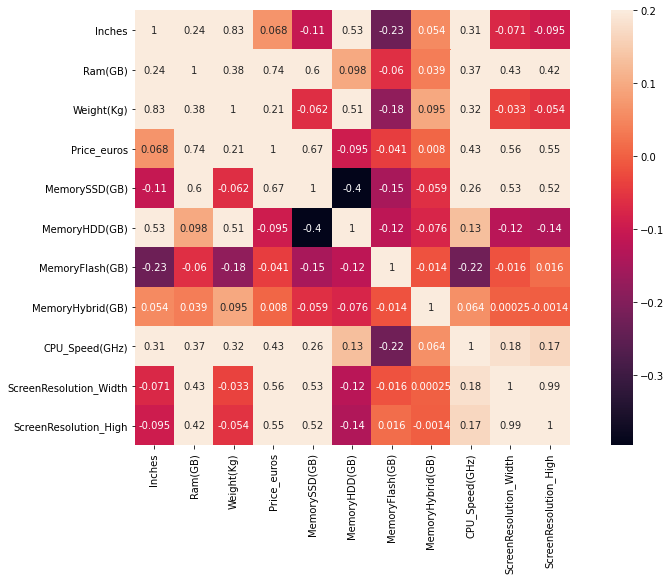

In [173]:
# Matriz de correlación:
corrmat = laptops_initial.corr()
f, ax = plt.subplots(figsize=(15, 8))
sns.heatmap(corrmat, annot=True, vmax=.2, square=True);


Tal y como se puede apreciar en el mapa de calor, la variable numérica con la que tiene más correlación el precio es con la cantidad de RAM que tenga el dispositivo, seguido de la cantidad de memoria SSD, la resolución de pantalla y la CPU que monte el dispositivo. Todas ellas, serán candidatas a formar parte del modelo de predicción del precio de un dispositivo.

Al contrario, las variables que menos influyen en la variabilidad de precio son el resto de tipos de almacenamiento (HDD, Flash e Híbrido), así como las pulgadas del portátil. El peso, pese a que influye en la valoración del portátil, lo hace de forma muy débil.

Dado que se identifica que la resolución de pantalla a lo ancho y alto están completamente correladas entre sí, se elimina la columna ScreenResolution_High para evitar redundancias.

In [174]:
# Eliminación de la columna redundante ScreenResolution_High
del laptops_initial['ScreenResolution_High']

## **Relación con variables categóricas**


A continuación, vamos a estudiar con más detalle algunas de las variables categóricas que pensamos pueden afectar más al rendimiento del modelo, para identificar visualmente si vemos conveniente que también formen parte del mismo:

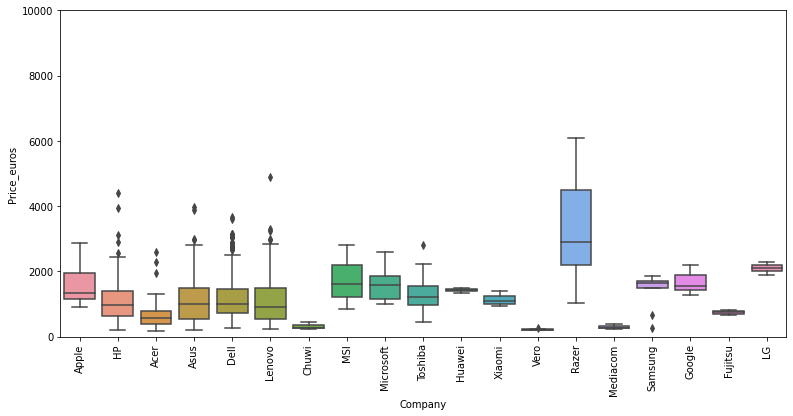

In [175]:
# Boxplot Company/Price_euros:

var = 'Company'
data = pandas.concat([laptops_initial['Price_euros'], laptops_initial[var]], axis=1)
f, ax = plt.subplots(figsize=(13, 6))
fig = sns.boxplot(x=var, y="Price_euros", data = data)
fig.axis(ymin=0, ymax=10000);
plt.xticks(rotation=90);

Respecto a las marcas, si bien hay algunas con rangos claramente superiores o inferiores, la mayoría de ellas mantienen una media de precios estable entorno a los 1000-2000€, rango que por otra parte se ha comprobado anteriormente como la media del dataset. En este sentido, no haremos uso de esta variable para el modelo.

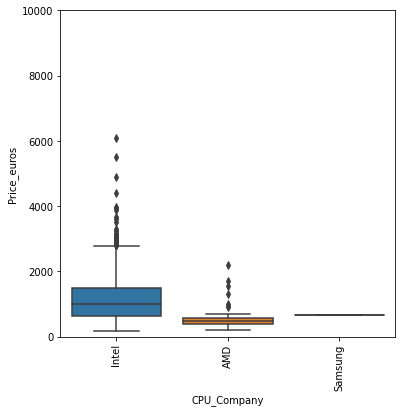

In [176]:
# Boxplot CPU_Company/Price_euros:

var = 'CPU_Company'
data = pandas.concat([laptops_initial['Price_euros'], laptops_initial[var]], axis=1)
f, ax = plt.subplots(figsize=(6, 6))
fig = sns.boxplot(x=var, y="Price_euros", data = data)
fig.axis(ymin=0, ymax=10000);
plt.xticks(rotation=90);

En este caso, se ve una clara diferencia de medias entre las CPU de Intel y las de AMD, que son las dos que abarcan la mayoría de dispositivos. Vemos conveniente por tanto disponer de dicha información en el modelo.

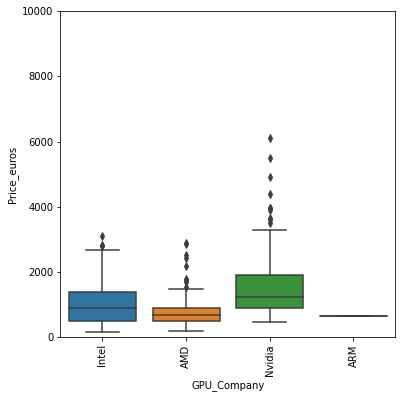

In [177]:
# Boxplot GPU_Company/Price_euros:

var = 'GPU_Company'
data = pandas.concat([laptops_initial['Price_euros'], laptops_initial[var]], axis=1)
f, ax = plt.subplots(figsize=(6, 6))
fig = sns.boxplot(x=var, y="Price_euros", data = data)
fig.axis(ymin=0, ymax=10000);
plt.xticks(rotation=90);

En este caso, aunque no de forma tan clara como en el de las CPU, se pueden apreciar lo que serían 3 gamas de GPU. De más barata a más cara estarían: AMD, Intel y Nvidia. Por lo tanto, consideramos relevante añadirlo al modelo.

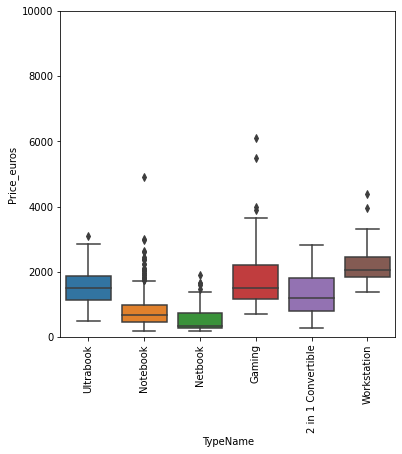

In [178]:
# Boxplot TypeName/Price_euros:

var = 'TypeName'
data = pandas.concat([laptops_initial['Price_euros'], laptops_initial[var]], axis=1)
f, ax = plt.subplots(figsize=(6, 6))
fig = sns.boxplot(x=var, y="Price_euros", data = data)
fig.axis(ymin=0, ymax=10000);
plt.xticks(rotation=90);

En tipos de dispositivos, si bien hay alguna categoría que destaca (como Gaming), el resto de dispositivos parece que abarcan una franja amplia de precios, con lo que no se ve recomendable incorporarla al modelo. 

A continuación procedemos a codificar las variables categóricas como numéricas mediante el método de one-hot para su inclusión en el modelo que generaremos a posteriori. Dado que desgranamos una variable categórica en tantas variables como categorias tenga (k), siempre podremos eliminar una de estas variables resultantes para mejorar el rendimiento del modelo y evitar redundancias.

In [179]:
# One-Hot de CPU_Company
dummies = pandas.get_dummies(laptops_initial['CPU_Company'], drop_first = True)
dummies = dummies.rename(columns={"Intel": "CPU_Intel", "Samsung": "CPU_Samsung"})
laptops_initial = laptops_initial.join(dummies)
laptops_initial

,Company,TypeName,Inches,Ram(GB),OpSys,Weight(Kg),Price_euros,MemorySSD(GB),MemoryHDD(GB),MemoryFlash(GB),MemoryHybrid(GB),CPU_Company,CPU_Version,CPU_Speed(GHz),GPU_Company,GPU_Version,ScreenResolution_Type,ScreenResolution_Width,CPU_Intel,CPU_Samsung
0,Apple,Ultrabook,13.3,8,macOS,1.37,1339.69,128.0,0.0,0.0,0.0,Intel,Core i5,2.3,Intel,Iris Plus Graphics 640,IPS Panel Retina Display,2560,1,0
1,Apple,Ultrabook,13.3,8,macOS,1.34,898.94,0.0,0.0,128.0,0.0,Intel,Core i5,1.8,Intel,HD Graphics 6000,Unknown,1440,1,0
2,HP,Notebook,15.6,8,No OS,1.86,575.00,256.0,0.0,0.0,0.0,Intel,Core i5 7200U,2.5,Intel,HD Graphics 620,Full HD,1920,1,0
3,Apple,Ultrabook,15.4,16,macOS,1.83,2537.45,512.0,0.0,0.0,0.0,Intel,Core i7,2.7,AMD,Radeon Pro 455,IPS Panel Retina Display,2880,1,0
4,Apple,Ultrabook,13.3,8,macOS,1.37,1803.60,256.0,0.0,0.0,0.0,Intel,Core i5,3.1,Intel,Iris Plus Graphics 650,IPS Panel Retina Display,2560,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1298,Lenovo,2 in 1 Convertible,14.0,4,Windows 10,1.80,638.00,128.0,0.0,0.0,0.0,Intel,Core i7 6500U,2.5,Intel,HD Graphics 520,IPS Panel Full HD / Touchscreen,1920,1,0
1299,Lenovo,2 in 1 Convertible,13.3,16,Windows 10,1.30,1499.00,512.0,0.0,0.0,0.0,Intel,Core i7 6500U,2.5,Intel,HD Graphics 520,IPS Panel Quad HD+ / Touchscreen,3200,1,0
1300,Lenovo,Notebook,14.0,2,Windows 10,1.50,229.00,0.0,0.0,64.0,0.0,Intel,Celeron Dual Core N3050,1.6,Intel,HD Graphics,Unknown,1366,1,0
1301,HP,Notebook,15.6,6,Windows 10,2.19,764.00,0.0,1024.0,0.0,0.0,Intel,Core i7 6500U,2.5,AMD,Radeon R5 M330,Unknown,1366,1,0


In [180]:
# One-Hot de GPU_Company
dummies = pandas.get_dummies(laptops_initial['GPU_Company'], drop_first = True)
dummies = dummies.rename(columns={"ARM": "GPU_ARM", "Intel": "GPU_Intel", "Nvidia": "GPU_Nvidia"})
laptops_initial = laptops_initial.join(dummies)
laptops_initial

,Company,TypeName,Inches,Ram(GB),OpSys,Weight(Kg),Price_euros,MemorySSD(GB),MemoryHDD(GB),MemoryFlash(GB),MemoryHybrid(GB),CPU_Company,CPU_Version,CPU_Speed(GHz),GPU_Company,GPU_Version,ScreenResolution_Type,ScreenResolution_Width,CPU_Intel,CPU_Samsung,GPU_ARM,GPU_Intel,GPU_Nvidia
0,Apple,Ultrabook,13.3,8,macOS,1.37,1339.69,128.0,0.0,0.0,0.0,Intel,Core i5,2.3,Intel,Iris Plus Graphics 640,IPS Panel Retina Display,2560,1,0,0,1,0
1,Apple,Ultrabook,13.3,8,macOS,1.34,898.94,0.0,0.0,128.0,0.0,Intel,Core i5,1.8,Intel,HD Graphics 6000,Unknown,1440,1,0,0,1,0
2,HP,Notebook,15.6,8,No OS,1.86,575.00,256.0,0.0,0.0,0.0,Intel,Core i5 7200U,2.5,Intel,HD Graphics 620,Full HD,1920,1,0,0,1,0
3,Apple,Ultrabook,15.4,16,macOS,1.83,2537.45,512.0,0.0,0.0,0.0,Intel,Core i7,2.7,AMD,Radeon Pro 455,IPS Panel Retina Display,2880,1,0,0,0,0
4,Apple,Ultrabook,13.3,8,macOS,1.37,1803.60,256.0,0.0,0.0,0.0,Intel,Core i5,3.1,Intel,Iris Plus Graphics 650,IPS Panel Retina Display,2560,1,0,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1298,Lenovo,2 in 1 Convertible,14.0,4,Windows 10,1.80,638.00,128.0,0.0,0.0,0.0,Intel,Core i7 6500U,2.5,Intel,HD Graphics 520,IPS Panel Full HD / Touchscreen,1920,1,0,0,1,0
1299,Lenovo,2 in 1 Convertible,13.3,16,Windows 10,1.30,1499.00,512.0,0.0,0.0,0.0,Intel,Core i7 6500U,2.5,Intel,HD Graphics 520,IPS Panel Quad HD+ / Touchscreen,3200,1,0,0,1,0
1300,Lenovo,Notebook,14.0,2,Windows 10,1.50,229.00,0.0,0.0,64.0,0.0,Intel,Celeron Dual Core N3050,1.6,Intel,HD Graphics,Unknown,1366,1,0,0,1,0
1301,HP,Notebook,15.6,6,Windows 10,2.19,764.00,0.0,1024.0,0.0,0.0,Intel,Core i7 6500U,2.5,AMD,Radeon R5 M330,Unknown,1366,1,0,0,0,0


Para tratar de ver el efecto real de estas variables, ejecutaremos de nuevo la matriz de correlación y veremos si la relación entre las variables que hemos pasado a numéricas y el precio es buena para incluirlas en el modelo.

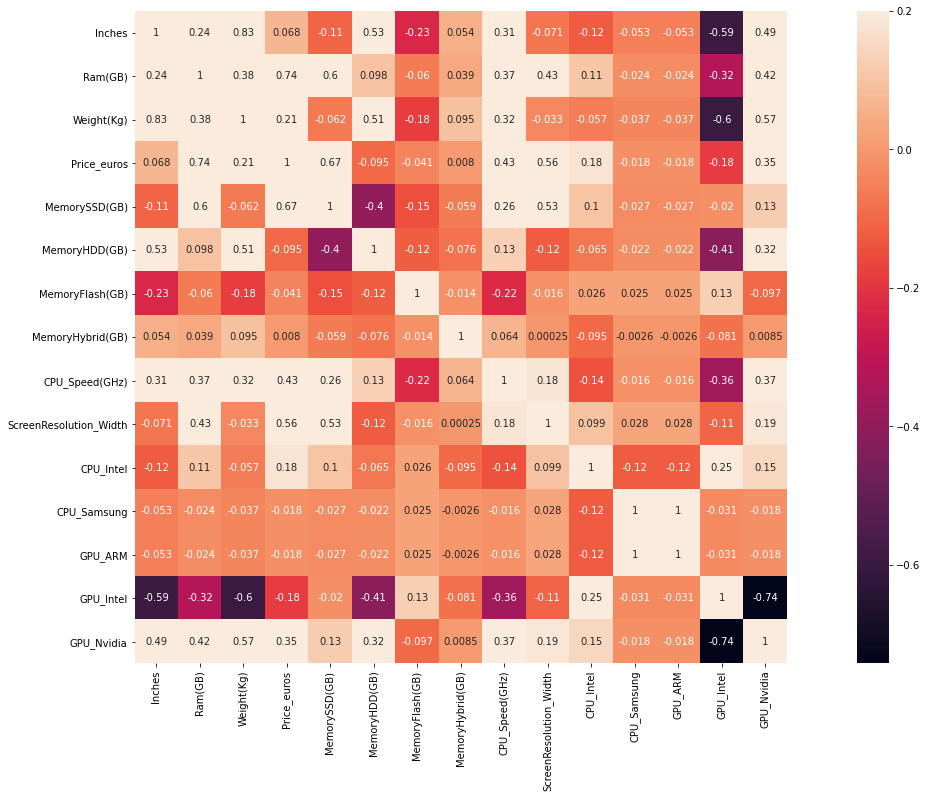

In [181]:
# Matriz de correlación:

corrmat = laptops_initial.corr()
f, ax = plt.subplots(figsize=(25, 12))
sns.heatmap(corrmat, annot=True, vmax=.2, square=True);

A partir de los resultados, vemos que la única variables que podría ser relevante para el modelo es la de GPU_Nvidia, al tener una correlación con el precio de 0.35. También podría llegar a ser candidata CPU_Intel, al haber obtenido un 0.18 de correlación. 

## **Creación y evaluación del modelo**

In [182]:
# Generación del dataset para cargar en el modelo con las columnas seleccionadas
laptops_finished = laptops_initial[["Ram(GB)", "Weight(Kg)", "MemorySSD(GB)", "CPU_Speed(GHz)", "ScreenResolution_Width", "GPU_Nvidia", "Price_euros"]]

In [183]:
# Normalización de los valores del dataset
cols_to_normalize = ["Ram(GB)", "Weight(Kg)", "MemorySSD(GB)", "CPU_Speed(GHz)", "ScreenResolution_Width", "GPU_Nvidia"]
scaler = MinMaxScaler()
laptops_finished = pandas.DataFrame(scaler.fit_transform(laptops_finished[cols_to_normalize].values), columns=cols_to_normalize, index=laptops_finished[cols_to_normalize].index).join(laptops_finished["Price_euros"])
laptops_finished.head(5)

,Ram(GB),Weight(Kg),MemorySSD(GB),CPU_Speed(GHz),ScreenResolution_Width,GPU_Nvidia,Price_euros
0,0.096774,0.169576,0.125,0.518519,0.482619,0.0,1339.69
1,0.096774,0.162095,0.000,0.333333,0.029911,0.0,898.94
2,0.096774,0.291771,0.250,0.592593,0.223929,0.0,575.00
3,0.225806,0.284289,0.500,0.666667,0.611964,0.0,2537.45
4,0.096774,0.169576,0.250,0.814815,0.482619,0.0,1803.60


A continuación, procederemos a dividir el dataset en un subset de entrenamiento y otro de test para evaluar el rendimiento del modelo.

In [184]:
# Hacemos uso de la librería sklearn para dividir en conjunto de train y test
train, test = train_test_split(laptops_finished, test_size = 0.30)
print(test.head(5))

      Ram(GB)  Weight(Kg)  ...  GPU_Nvidia  Price_euros
992  0.032258    0.301746  ...         0.0       270.62
734  0.096774    0.187032  ...         0.0       960.00
747  0.096774    0.291771  ...         0.0       539.00
704  0.032258    0.301746  ...         0.0       450.00
303  0.096774    0.376559  ...         1.0       549.00

[5 rows x 7 columns]


In [185]:
x_train = train[cols_to_normalize]
y_train = train["Price_euros"]

x_test = test[cols_to_normalize]
y_test = test["Price_euros"]

# Creación del modelo de regresión lineal
model = LinearRegression().fit(x_train, y_train)
r_sq = model.score(x_train, y_train)
print('coefficient of determination:', round(r_sq, 2))

# Evaluación del modelo con los datos de test
y_pred = model.predict(x_test)
pred_price = pandas.DataFrame({'Actual': y_test, 'Predicted': y_pred})
print(pred_price)

coefficient of determination: 0.7
       Actual    Predicted
992    270.62   394.017455
734    960.00  1201.556076
747    539.00  1101.251787
704    450.00   442.148580
303    549.00   862.639445
...       ...          ...
166    363.51   264.933084
44     999.00  1086.298481
1178  2153.37  1670.507931
1253  1072.00  1159.684344
1215   174.00   252.131157

[391 rows x 2 columns]
